## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import nltk

In [2]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
from wordcloud import WordCloud,STOPWORDS

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

### Web Scraping

In [5]:
import requests
from bs4 import BeautifulSoup 

In [6]:
reviews = []
ratings = []

In [7]:
for i in range(1,31):
    links = requests.get('https://www.amazon.in/Apple-MWP22HN-A-AirPods-Pro/product-reviews/B07ZRXF7M8/ref=cm_cr_getr_d_paging_btm_prev_1?ie=UTF8&reviewerType=all_reviews&pageNumber='+str(i)).text
    soup = BeautifulSoup(links,'lxml')
    comments = soup.find_all('a', class_='a-size-base a-link-normal review-title a-color-base review-title-content a-text-bold')
    for i in range(0,len(comments)):
        reviews.append(comments[i].get_text().replace('\n',''))
    stars = soup.find_all('i',class_='review-rating')
    for i in range(0,len(stars)):
        ratings.append(stars[i].get_text().replace('\n',''))
        if i<2:
            ratings.pop()

In [8]:
df = pd.DataFrame()

In [9]:
df['reviews'] = reviews
df['ratings'] = ratings

In [10]:
df.sample(10)

,reviews,ratings
64,Was expecting this to be better than AirPods.,4.0 out of 5 stars
44,After a long time apple made such a solid prod...,3.0 out of 5 stars
24,My airpods pro not getting on its dead on arrival,1.0 out of 5 stars
116,Wow,5.0 out of 5 stars
75,Good product but lengthy service to resolve is...,5.0 out of 5 stars
91,Expensive but worth the quality,4.0 out of 5 stars
108,Big NO to apple products from amazon,1.0 out of 5 stars
29,Fake product received,1.0 out of 5 stars
47,DO NOT BUY from Amazon,1.0 out of 5 stars
83,It's Airpods Pro what else you can expect,4.0 out of 5 stars


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  120 non-null    object
 1   ratings  120 non-null    object
dtypes: object(2)
memory usage: 2.0+ KB


In [12]:
df.describe()

,reviews,ratings
count,120,120
unique,119,5
top,Amazing,1.0 out of 5 stars
freq,2,48


#### Saving the data as .csv file.

In [13]:
df.to_csv(r'C:\Users\Lance Machado\Desktop\Assignments\Text Mining\Airpod_reviews.csv',index=True)

#### Converting ratings from type string to float, for easy evaluation.

In [14]:
def rate(x):
    stars = x.split()
    return float(stars[0])

In [15]:
df['ratings'] = df['ratings'].apply(lambda x:rate(x))

In [16]:
df['sentiment'] = df['ratings'].apply(lambda r: 'positive' if r > 3 else 'negative' if r < 3 else 'neutral')
df.head()

,reviews,ratings,sentiment
0,Selling China products and charging for origin...,1.0,negative
1,Defective AirPods pro,1.0,negative
2,Okay sound. Great convenience. Excellent pair ...,4.0,positive
3,Be aware of replacement policy,1.0,negative
4,Check serial no. Of apple products on apple co...,1.0,negative


#### Cleaning the tweets (removing @'s and emojis )

In [17]:
new = []
for t in df['reviews']:
    words = t.split()
    t = t.split()
    t = ' '.join(word for word in t if not word.startswith('@'))
    t = t.split()
    t = ' '.join(word for word in t if not word.startswith('http'))
    t = re.sub('\w*\d\w*', '', t)
    t = re.sub('[^a-zA-Z0-9]'," ",t.lower())
    new.append(t)
    
df['reviews'] = new

In [18]:
df.head(5)

,reviews,ratings,sentiment
0,selling china products and charging for origin...,1.0,negative
1,defective airpods pro,1.0,negative
2,okay sound great convenience excellent pair ...,4.0,positive
3,be aware of replacement policy,1.0,negative
4,check serial no of apple products on apple co...,1.0,negative


In [19]:
stop = stopwords.words('english')
df['reviews'] = df['reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [20]:
cv = CountVectorizer()

In [21]:
df_cv = cv.fit_transform(df['reviews'])
data_stop = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names_out())
data_stop.index = df.index

In [22]:
data_stop.head(5)

,absolutely,active,actually,addition,airpod,airpods,allrounder,amazing,amazon,anc,...,wireless,wish,without,working,worse,worst,worth,worthy,wow,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Wordcloud for entire corpus

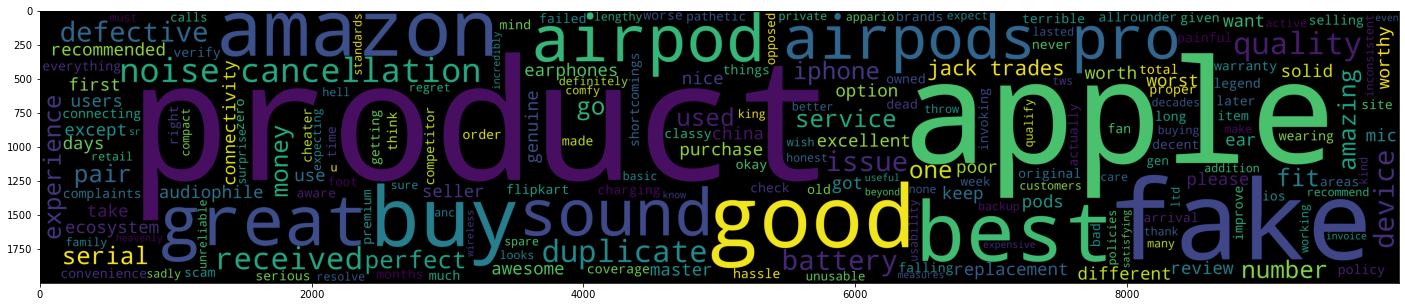

In [23]:
string_Total = " ".join(df['reviews'])
wordcloud_stw = WordCloud(
                background_color= 'black',
                width = 10000,
                height = 2000
                ).generate(string_Total)
plt.figure(figsize=(30,5))
plt.imshow(wordcloud_stw)

### Sentiment Analysis

In [24]:
sia = SentimentIntensityAnalyzer()

In [25]:
df['scores'] = df['reviews'].apply(lambda reviews: sia.polarity_scores(reviews))
df['scores'] = df['scores'].apply(lambda score_dict: score_dict['compound'])

In [26]:
df['predicted_sentiment'] = df['scores'].apply(lambda c: 'positive' if c > 0 else 'negative' if c < 0 else 'neutral')

In [27]:
df.sample(10)

,reviews,ratings,sentiment,scores,predicted_sentiment
88,want genuine apple product please buy amazon,1.0,negative,0.5106,positive
62,many issues,1.0,negative,0.0000,neutral
22,good zero complaints,5.0,positive,0.0516,positive
66,jack trades,5.0,positive,0.0000,neutral
9,different serial numbers everything,1.0,negative,0.0000,neutral
7,solid product apple,4.0,positive,0.1531,positive
74,good addition apple family,5.0,positive,0.4404,positive
96,worth,1.0,negative,0.2263,positive
67,nice product apple,5.0,positive,0.4215,positive
71,noise cancellation best,5.0,positive,0.6369,positive


<AxesSubplot:xlabel='predicted_sentiment', ylabel='count'>

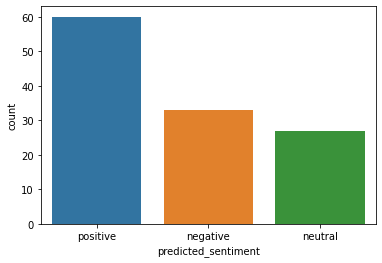

In [28]:
sns.countplot(x=df['predicted_sentiment'])